<a href="https://colab.research.google.com/github/MingxiZhang99/computer-programming/blob/main/lab3_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning lab 3: Graph Neural Networks

This material is largly based on the GNN lab first designed for the Deep Learning course at Linköping University developed by Filip Ekström Kelvinius and Fredrik Lindsten.

The aim with this lab is that you get to familiarize yourself a bit more with graph neural networks (GNNs). You will do some theoretical work, using the message passing neural network-framework presented in the lectures, but mostly you will put this into practice and implement a GNN using [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/#) (PyG), which is a library built on top of PyTorch for working with GNNs of all kinds.

## Install and load required packages

Note that for pytorch_geometric, you should have the pytorch version 2.5.1 installed for the best experience of this lab. For this lab we recommend using GPU acceleration to enable a fast training for which you can use for example google colab.

**Running on google colab**: If you are running this notebook on google colab, you need to upload the additionally provided python scipts from the zip file in order to run the code provided within them that this notebook relies on. Therefore, after you have connected to a runtime, go to the files tab on the left-hand side menu of colab and press the buttom to upload the two provided python scripts into the session stoarge. Note that you need to reupload the files if you restart the session as they are not permanantly stored.

In [1]:
# pytorch geometric dependencies:
! pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# for gpu installation use this line:
! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cu124.html
# use the following line instead when running on a cpu only machine:
# ! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cpu.html

# dependencies for the molecular data
! pip install ase

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.0 MB/s eta 0:00:00


In [2]:
import torch
import torch_geometric as pyg
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation

# some helper functions for the lab
from utils import load_toy_data, generate_otf_graph
from coll_data import get_coll_loaders, batch_to_atoms

import ase

## Preliminaries: Data and batching in PyG

PyG is built on top of PyTorch, and in that sense is very similar to what you have already seen. However, graphs are structured a bit differently compared to, e.g., images. For example, the sizes of different samples can be very different, and a graph consists of different parts like node features, edges, and edge features and unlike for text sequences there is no clear way to truncate the data in order to obtain samples of equal length. PyG helps keeping track and organize this using ```pyg.data.Data``` (for a single instance of a graph) and ```pyg.loader.DataLoader``` (a custom DataLoader for batching data).

### PyTorch Geometric data
First, lets take a look at two toy graphs, illustrated below. The numbers represent indices, and the colors indicate the type of the node.
In the following, we look at some toy data and examine the internals of pytorch geometric data representation.

_Note: If the image below is not showing due to your notebook enviornment, you can also manually inspect the image file contained in the zip folder that includes all the assignment material._

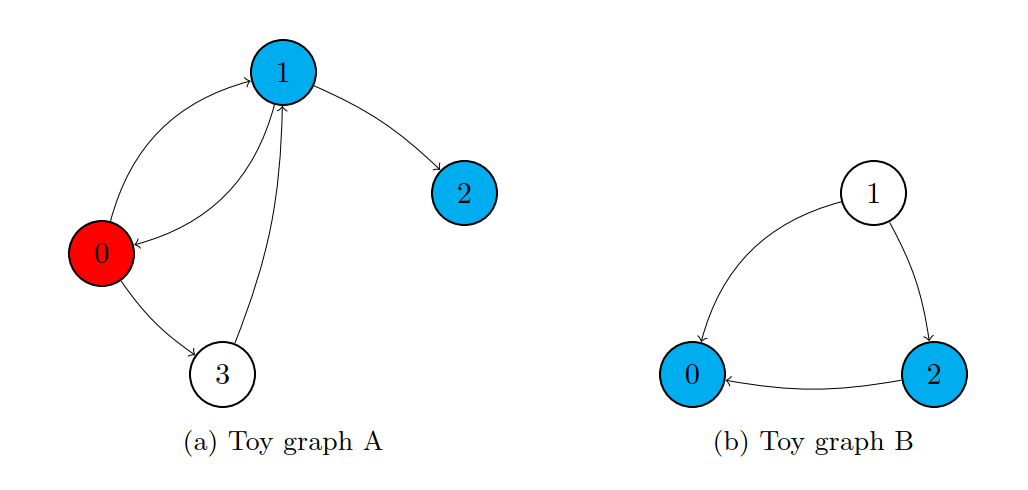

PyG's representations of these can be loaded using ```load_toy_data()``` which returns the two graphs as ```pyg.data.Data``` objects. Try printing the contents, then answer the questions below about how the graphs are stored in the framework.

In [3]:
# load the two toy graphs.
data1, data2 = load_toy_data()

In [4]:
# look at data1 and data2 and their content to answer the question below.
print("data 1")
print(data1)
print(data1.x)
print(data1.edge_index)

print()

print("data 2")
print(data2)
print(data2.x)
print(data2.edge_index)

data 1
Data(x=[4, 1], edge_index=[2, 5])
tensor([[3],
        [2],
        [2],
        [1]])
tensor([[1, 0, 3, 1, 0],
        [0, 1, 1, 2, 3]])

data 2
Data(x=[3, 1], edge_index=[2, 3])
tensor([[2],
        [1],
        [2]])
tensor([[1, 2, 1],
        [0, 0, 2]])


**Question 1:** Which of ```data1``` and ```data2``` correspond to graph A and B? Include a short motivation based on the output of your code.

data1 corresponds to Graph A.
4 rows means 4 features, matches Graph A has 4 nodes.
Edge from 1 → 0
Edge from 0 → 1
Edge from 3 → 1
Edge from 1 → 2
Edge from 0 → 3

data2 corresponds to Graph B.
3 rows means 3 features, matches Graph B has 3 nodes.
Edge from 1 → 0
Edge from 2 → 0
Edge from 1 → 2

### Batching

Now, let's take a look at how batching works in PyG. Create a PyG dataloader with ```data1``` and ```data2``` and
check the content of the resulting batch to answer the two questions below.

In [5]:
# create dataloader and get the first batch.
dataloader = pyg.loader.DataLoader([data1, data2], batch_size=2)
data_batch = next(iter(dataloader))

In [6]:
# play around with data_batch
print(data_batch)

print(data_batch.x)
print(data_batch.edge_index)
print(data_batch.batch)

DataBatch(x=[7, 1], edge_index=[2, 8], batch=[7], ptr=[3])
tensor([[3],
        [2],
        [2],
        [1],
        [2],
        [1],
        [2]])
tensor([[1, 0, 3, 1, 0, 5, 6, 5],
        [0, 1, 1, 2, 3, 4, 4, 6]])
tensor([0, 0, 0, 0, 1, 1, 1])


**Question 2**: What is the purpose of the ```batch``` attribute in the ```data_batch``` object? What else is contained in the data batch?

**Answer:**

allows PyG to differentiate and process multiple graphs simultaneously in a mini-batch, enabling efficient parallel computation.

x: Contains features of all nodes from both graphs.
edge_index: Stores edge connections for all graphs.
batch: Maps each node to its corresponding graph (0 for the first graph, 1 for the second).
ptr: Marks the boundary between graphs, helping PyG manage graph separation within the batch.

**Question 3**: What happened to ```edge_index``` when batching the two graphs? Why?

**Answer**:

## Preliminaries: Molecules as graphs

The dataset that you will work with is a molecular dataset, and as that probably is a new type of application for you, this section aims at giving a brief introduction to how molecules can be represented as graphs.

In the lab, the task of the GNN is to predict the energy $E$ of a molecule consisting of $N$ atoms (nodes). We can describe this mathematically as

$$
\hat{E} = GNN [ \mathbf{Z}, \mathbf{v} ]
$$

where the input data consists of the coordinates of each atom in the molecule $\mathbf{Z} \in \mathbb{R}^{3 \times N}$ and $\mathbf{v} \in \mathbb{Z}^N$ describing the atomic number of each atom in the molecule.
We use the one-hot encoding of the atomic number in order to design the node features of the input graph.
Since there are 118 atoms in the atomic table, the one-hot encoded node features are stored in a matrix $\mathbf{X}$ of size $118 \times N$.
The positions of the atoms are used to construct edge features such as the distance length and the direction between the individual atoms.
We can either use the 3-D distance vector between the nodes as the edge features or the length of the distance vector as we will discuss throughout this lab.
This leads to either $D_E = 1$ or $D_E = 3$ depending on which model we use.

From the input to the GNN (consisting of $\mathbf{Z}$ and $\mathbf{v}$), it is rather straight forward to construct a graph: each atom correspond to a node, and we can create edges between atoms that are within a certain distance from each other. The node features could then be the type of atom, and edge features could incorporate geometric information like distance between the atoms.
Note that in this lab we do not use additional information about the molecule such as the bonds between the individual atoms.

**Question 4**: What kind of task (graph-, node-, edge-level) is the task in this lab? Is it a classification or a regression task?

**Answer**:

graph-level task, because the goal is to predict a property (energy $E$) of the entire molecule, not individual nodes (atoms) or edges (bonds).

regression task, as energy ($E$) is a continuous value rather than a discrete class label.

## Deriving MPNN equations

There is a wide variety of different GNN layers. The choice of particular scheme depends on many factors such as the application, types of graph and scale of the model.
PyG provides support for the message passing neural network (MPNN) framework. Therefore, it is rather straightforward to implement a GNN if you have derived the functions $m[\cdot, \cdot, \cdot]$ and $u[\cdot, \cdot]$ from the message-passing framework.
Each function can use additionally parameters that are learnable during the training.

In this lab, you will work with a GNN called [CGCNN](https://arxiv.org/pdf/1710.10324.pdf) and which has been developed for chemistry applications. To implement this model in PyG, we will start by deriving the MPNN equations for CGCNN. In the original paper, they use the equation (compare eq. 5 in the paper with slightly different notation) to compute the output of a single layer:
$$
\mathbf{h}_{k+1}^{(i)}  = \mathbf{h}^{(i)}_{k} + \sum_{j\in \text{ne}[i]} \mathbf{a}_1 \left[ \mathbf{\Omega}_k^{f}\mathbf{z}^{(j, i)}_k + \boldsymbol{\beta}_k^{f} \right] \odot \mathbf{a}_2\left[ \mathbf{\Omega}_k^{s}\mathbf{z}^{(j, i)}_k + \boldsymbol{\beta}_k^{s} \right]
$$
to describe their updates to the node features $\mathbf{h}^{(i)}$ of the corresponding node $i$ and the subscript indicates the number of the hidden layer $k$ that is used. Here, $\mathbf{\Omega}$ and $\boldsymbol{\beta}$ denote weight matrices and vectors and we  use $s$ and $f$ two differentiate between the two sets of weight matrices and bias terms. Each set parameterizes a fully-connected linear layer. The functions $\mathbf{a}_1[\cdot]$ and $\mathbf{a}_2[\cdot]$ are two different non-linear activation functions operating element-wise, $\odot$ means element-wise multiplication, and $\mathbf{z}^{(j, i)} = \mathbf{h}^{(i)} \oplus \mathbf{h}^{(j)} \oplus \mathbf{e}^{(j, i)}$ is the concatenation of node and edge feature vectors.

_Note that in this notebook we use $\text{ne}[i]$ in order to denote the neighbourhood of node $i$ as done in the course book rather than $\mathcal{N}_i$._

**Question 5**: Given the equation above, re-write this according to the general MPNN-equations from the lectures

**Answer**: _You can either write the equations in latex here or present the solution to us in handwritten form._

**Question 6**: How are the incoming messages aggregated in the CGCNN network?

**Answer**:

CGCNN uses summation (Sum) as the message aggregation function. All messages from neighboring nodes are aggregated through addition and ultimately used to update the node features. This aggregation method is very common in MPNNs because it offers good robustness to the number of nodes (graph size).

## Implementing a CGCNN layer
Now it is time to put these equations into practice and create a CGCNN layer, using the ```MessagePassing``` class from PyG.

It might help to read through the **intro** and the **part about the Messsage Passing base class** in the PyG [tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html). **Note**: the function ```MessagePassing.update()``` has according to the developers been phased out. We make the update inside ```forward``` instead, after having called ```propagate().```

Then implement the equations that you derived. In the CGCNN paper, it is specified that $\mathbf{a}_1[\cdot] = \text{sigmoid}[\cdot]$ to implement a _gating_ mechanism. For $\mathbf{a}_2[\cdot]$, we can use $\text{softplus}[\cdot]$ for the activation functions.

**Task 1**: Implement the **derived message passing equations** in the CGCNN layer in the Message Passing class below. The message class implements the message computation. By **calling .propagate in the forward class**, all messages get computed and aggregated using the chosen aggregation function of the message passing scheme.


**Task 2**: In order to get good performance later during the lab, **add a BatchNorm both after computing the linear part of the messages and after the aggregation of the messages.**


In [18]:
class CGCNNLayer(pyg.nn.MessagePassing):

    def __init__(self, node_fea_dim, edge_fea_dim):
        # choose appropiate aggregation function
        aggregation = "sum" # TODO: choose the aggregation as a string
        super().__init__(aggr=aggregation)  # aggregation function of messages
        # Batch norm is not included in the MPNN equations, but should be applied on two occasions:
        # 1. Before the activation funtctions sigma and g are applied
        # 2. On the message after aggregation (i.e., from whatever is returned from self.propagate)
        # Define linear layers for message computation
        self.linear_f = nn.Linear(node_fea_dim * 2 + edge_fea_dim, node_fea_dim)
        self.linear_s = nn.Linear(node_fea_dim * 2 + edge_fea_dim, node_fea_dim)
        # Batch normalization layers
        # 1. Before activation functions (sigmoid and softplus)
        self.bn1_f = nn.BatchNorm1d(node_fea_dim)  # Before sigmoid
        self.bn1_s = nn.BatchNorm1d(node_fea_dim)  # Before softplus

        # 2. After message aggregation (from self.propagate)
        self.bn2 = nn.BatchNorm1d(node_fea_dim)

        # Define activation functions
        self.sigmoid = nn.Sigmoid()   # Gating mechanism
        self.softplus = nn.Softplus() # Softplus activation function

    def forward(self, h, edge_index, edge_attr):
        # call propagate to compute messages and aggregate them.
        # edge_index always need to be included, then we can add names arguments that will be passed to, e.g., message
        m = self.propagate(edge_index, h=h, e=edge_attr)

        # remember batch norm on output from propagate.
        m = self.bn2(m)

        # TODO: implement the node update function.
        out = h+m
        # return the updated features.
        return out

    def message(self, h_i, h_j, e):
        # implementation of M_t
        # appending _i or _j to name of a variable that was passed to propagate will map it to the corresponding node
        z = torch.cat([h_i, h_j, e], dim=1)

        # TODO: implement the message function
        f = self.bn1_f(self.linear_f(z))
        s = self.bn1_s(self.linear_s(z))

        # Apply activation functions
        a1 = self.sigmoid(f)      # Gating mechanism
        a2 = self.softplus(s)     # Softplus activation

        # Element-wise multiplication (gating)
        out = a1 * a2

        return out



## CGCNN Network
Now once we have implemented the layer, we can use it in a full CGCNN model. This is still a ```torch.nn.Module``` (so nothing new just because we are working with GNNs), but the layers will be instances of your ```CGCNNLayer``` from before.

The forward pass through the model should compute the following steps:

1. Embed the nodes into node features
1. Iterate over the CGCNN layers
    1. Pass through the layer
    1. Batch norm
    1. Activation function (for example, softplus)
1. Pool node features using mean pooling
1. Pass pooled representation through final MLP

As this is a graph level task we need to pool the information of the nodes to a global feature representation. To perform the pooling of node features, PyG provides [pooling layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#pooling-layers). CGCNN uses mean pooling, so take a look at the documentation of [pyg.nn.pool.global_mean_pool](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_mean_pool.html#torch_geometric.nn.pool.global_mean_pool).

**Task 3**: Implement the forward pass through the model in the created network.

In [19]:
class CGCNN(torch.nn.Module):

    def __init__(self, node_fea_dim, invariant, num_layers, cutoff, max_neighbors):
        super().__init__()

        # parameters to generate the graph from the molecular structure
        self.cutoff = cutoff
        self.max_neighbors = max_neighbors
        self.pbc = False  # Keep this when using the COLL dataset

        # the invariant model uses one edge feature, the regular three.
        if invariant:
            edge_fea_dim = 1
        else:
            edge_fea_dim = 3
        self.edge_fea_dim = edge_fea_dim

        # Create an embedding layer (number of elements in embedding table=118)
        self.embed = torch.nn.Embedding(118, node_fea_dim)

        # Initialize the cgcnn layers, batch norm layers, and choose an activation function
        self.cgcnn_layers = torch.nn.ModuleList([CGCNNLayer(node_fea_dim, edge_fea_dim) for _ in range(num_layers)])
        self.bn_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(node_fea_dim) for _ in range(num_layers)])
        self.activation = torch.nn.Softplus()

        # Pool function
        self.pool = pyg.nn.pool.global_mean_pool

        # Create a small MLP that can take in the pooled representation, and output a prediction of the energy
        self.out_mlp = torch.nn.Sequential(torch.nn.Linear(node_fea_dim, 2*node_fea_dim),
                                     torch.nn.Softplus(),
                                     torch.nn.Linear(2*node_fea_dim, 1))

    def forward(self, data):
        # For this data, we construct the graph on the fly, but it is possible for other datasets to have data.edge_index, data.edge_attr etc
        edge_index, edge_dist, distance_vec = generate_otf_graph(data, self.cutoff, self.max_neighbors, self.pbc)
        edge_dist = edge_dist.unsqueeze(-1)

        if self.edge_fea_dim == 1:
            edge_attr = edge_dist
        else:
            edge_attr = distance_vec

        # TODO: implement the forward pass through the network.
        # Hint: the atomic number is stored at data.atomic_numbers.
         # Embed the nodes using the atomic numbers
        node_features = self.embed(data.atomic_numbers)

        # Iterate through CGCNN layers
        for i in range(len(self.cgcnn_layers)):
            node_features = self.cgcnn_layers[i](node_features, edge_index, edge_attr)
            # Apply batch normalization
            node_features = self.bn_layers[i](node_features)
            # Apply activation function
            node_features = self.activation(node_features)

        # Pool the node features using mean pooling
        pooled_features = self.pool(node_features, data.batch)

        # Pass through the final MLP to get the prediction
        prediction = self.out_mlp(pooled_features)

        return prediction


### Invariance
The task for the GNN in this lab is to predict the energy of the molecular system. This property is __invariant__ to any rigid transformations (i.e., rotations and/or translations) of the molecules; it does not matter if we move the molecule to a different position, or if it is rotated, it is still the same molecule with the same energy.

We can make the network invariant to such transformations by using only invariant features. The input to CGCNN consists of the atom types $\mathbf{v}$ from which the node features are constrcuted using a one-hot encoding and the atom positions $\mathbf{Z}$. The atom types are of course invariant to translations and rotations, so it is the geometric information in $\mathbf{Z}$ that needs consideration. CGCNN incorporates this geometric information in the edge features. Consider using as edge feature either 1) the distance between the two atoms or 2) the (three-dimensional) vector between the atoms.

**Question 7:** To what transformations (rotations, translations) are these respective features invariant?

**Answer**:The scalar distance between atoms is invariant to both translations and rotations.

In contrast, the 3D vector between atoms is invariant to translations but not invariant to rotations.

The vector feature is, however, equivariant to rotations, meaning it transforms in a predictable way under rotation.


Now let's take a look at this in practice. Load some data and use ```transform_and_visualize``` to apply a rotation and see how it looks like.

**Note**: the dataset we are working on in this lab is called COLL. You do not have to implement the dataset yourself, but PyG provides a custom dataset class called ```InMemoryDataset``` in which COLL has been implemented for this lab. If you are interested in how such a dataset could be constructed, you can take a look at ```coll_data.py``` to see the implementation, and you can read more in the [PyG tutorial on creating graph datasets](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html).

In [20]:
def transform_and_visualize(data):
    transformed_data = data.clone()
    rot_vec = np.array([1.0, 1.0, 0.0])
    rot_vec = rot_vec / np.linalg.norm(rot_vec)
    rot_angle = np.pi/3
    rotation_matrix = torch.tensor(Rotation.from_rotvec(rot_angle * rot_vec).as_matrix()).float()
    transformed_data.pos = torch.matmul(transformed_data.pos, rotation_matrix)
    fig, ax = plt.subplots(1, 2)
    atoms = batch_to_atoms(data)
    transformed_atoms = batch_to_atoms(transformed_data)

    ase.visualize.plot.plot_atoms(atoms[0], ax[0], rotation=("-75x, 45y, 10z"))
    ase.visualize.plot.plot_atoms(transformed_atoms[0], ax[1], rotation=("-75x, 45y, 10z"))

    ax[0].set_title("Original data")
    ax[1].set_title("Rotated data")
    plt.show()

    return data, transformed_data

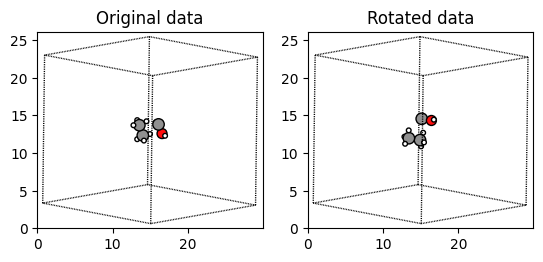

In [21]:
_, loader, _ = get_coll_loaders(5)  # returns train, val, test loaders. For now just using the val loader

data = next(iter(loader))
data, transformed_data = transform_and_visualize(data)

Now try instantiating a model that uses these different edge features by setting ```edge_fea_dim=1``` (only distances) or ```edge_fea_dim=3``` (vector between atoms), and make predictions for both ```data``` and ```transformed_data```.

In [22]:
# Reasonable values for cutoff and max_neighbors are 12 [Å] and 30, respectively. For now, number of layers doesn't matter
model_ = CGCNN(32, False, 5, 12, 30)
model_invariant = CGCNN(32, True, 5, 12, 30)

# disable gradient computations here:
with torch.no_grad():

    print("Regular model:")
    print("Output:\t\t\t", model_(data), "\nOutput transformed:\t", model_(transformed_data))

    print()
    print("Invariant model:")
    print("Output:\t\t\t", model_invariant(data), "\nOutput transformed:\t", model_invariant(transformed_data))

Regular model:
Output:			 tensor([[ 0.0105],
        [-0.0036],
        [ 0.0087],
        [ 0.0134],
        [ 0.0134]]) 
Output transformed:	 tensor([[ 0.0177],
        [-0.0030],
        [ 0.0058],
        [ 0.0142],
        [ 0.0123]])

Invariant model:
Output:			 tensor([[ 0.0706],
        [-0.1148],
        [ 0.1538],
        [ 0.1260],
        [ 0.1626]]) 
Output transformed:	 tensor([[ 0.0706],
        [-0.1148],
        [ 0.1538],
        [ 0.1260],
        [ 0.1626]])


**Question 8:** What do you see in the outputs? Is it what you expected?

**Answer**:
 the regular model is sensitive to transformations, as its predictions change when applied to transformed data.

 In contrast, the invariant model produces identical predictions for both the original and transformed data

## Task 4: Train a CGCNN model

In [23]:
device = "cpu" # todo: change to cuda if you are using gpu support.

In [24]:
train_loader, val_loader, test_loader = get_coll_loaders(256)

In [25]:
@torch.inference_mode()
def validate(model, loader, device):
    assert not model.training, "Model is in training mode"
    num_samples = 0
    total_sq_error = 0
    total_abs_error = 0

    for i, batch in enumerate(loader):
        batch = batch.to(device)
        batch_size = batch.y.shape[0]
        num_samples += batch_size

        pred = model(batch)
        mae = torch.nn.functional.l1_loss(pred, batch.y)
        mse = torch.nn.functional.mse_loss(pred, batch.y)

        total_sq_error += mse.item()*batch_size
        total_abs_error += mae.item()*batch_size

    avg_mse = total_sq_error / num_samples
    avg_mae = total_abs_error / num_samples
    return avg_mse, avg_mae

def train_and_test(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=10, device="cuda", save_name="best_parameters.pt", test_loader=None):
    model = model.to(device)
    model.train(True)
    best_val_error = 1e9

    for epoch in range(num_epochs):
        epoch_losses = []
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            batch = batch.to(device)

            pred = model(batch)
            loss = loss_fn(pred, batch.y)

            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        mean_epoch_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1} training loss: \t {mean_epoch_loss:.4f}")

        # Validation
        model.train(False)
        val_mse, val_mae = validate(model, val_loader, device)
        print(f"Epoch {epoch+1} validation MSE: {val_mse:.4f} \t MAE: {val_mae:.4f}")
        if val_mae < best_val_error:  # we choose MAE as preferred metric
            torch.save(model.state_dict(), save_name)  # save these model parameters
            best_val_error = val_mae
        model.train(True)

    print("Training finished!")
    model.train(False)

    if test_loader is not None:
        print("Evaluating on test set")
        model.load_state_dict(torch.load(save_name, weights_only=False))  # load best parameters, based on validation error (early stopping)
        test_mse, test_mae = validate(model, test_loader, device)
        print(f"Final test MSE: {test_mse:.4f}, \t MAE {test_mae:.4f}")

### Invariant model
Now it is time to train a model. Start with a completely invariant model (```edge_fea_dim=1```). After loading the data, initialize your model, choose an optimizer and loss function.

In [26]:
# Reasonable values for cutoff and max_neighbors are 12 [Å] and 30 max neighbours, respectively.
model_inv = CGCNN(node_fea_dim=32, invariant=True, num_layers=3, cutoff=12, max_neighbors=30)

# choose optimizer and loss function.
optimizer = torch.optim.AdamW(model_inv.parameters(), lr=0.0001)
loss_fn = torch.nn.L1Loss()

# run the training loop.
train_and_test(model_inv, optimizer, loss_fn, train_loader, val_loader, 30, device, "best_parameters_invariant.pt", test_loader)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([192])) that is different to the input size (torch.Size([192, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
<ipython-input-25-a942c988ce7d>:14: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = torch.nn.functional.l1_loss(pred, batch.y)
<ipyt

Epoch 1 training loss: 	 1.8893


<ipython-input-25-a942c988ce7d>:14: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = torch.nn.functional.l1_loss(pred, batch.y)
<ipython-input-25-a942c988ce7d>:15: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = torch.nn.functional.mse_loss(pred, batch.y)


Epoch 1 validation MSE: 0.3286 	 MAE: 0.3871
Epoch 2 training loss: 	 0.3776
Epoch 2 validation MSE: 0.3012 	 MAE: 0.3722
Epoch 3 training loss: 	 0.3695
Epoch 3 validation MSE: 0.2913 	 MAE: 0.3670
Epoch 4 training loss: 	 0.3646
Epoch 4 validation MSE: 0.2896 	 MAE: 0.3636
Epoch 5 training loss: 	 0.3615
Epoch 5 validation MSE: 0.2817 	 MAE: 0.3612
Epoch 6 training loss: 	 0.3601
Epoch 6 validation MSE: 0.2793 	 MAE: 0.3613
Epoch 7 training loss: 	 0.3595
Epoch 7 validation MSE: 0.2847 	 MAE: 0.3605
Epoch 8 training loss: 	 0.3592
Epoch 8 validation MSE: 0.2818 	 MAE: 0.3597
Epoch 9 training loss: 	 0.3590
Epoch 9 validation MSE: 0.2808 	 MAE: 0.3600
Epoch 10 training loss: 	 0.3588
Epoch 10 validation MSE: 0.2813 	 MAE: 0.3598
Epoch 11 training loss: 	 0.3587
Epoch 11 validation MSE: 0.2852 	 MAE: 0.3604
Epoch 12 training loss: 	 0.3585
Epoch 12 validation MSE: 0.2838 	 MAE: 0.3597
Epoch 13 training loss: 	 0.3584
Epoch 13 validation MSE: 0.2791 	 MAE: 0.3593
Epoch 14 training loss:

<ipython-input-25-a942c988ce7d>:14: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = torch.nn.functional.l1_loss(pred, batch.y)
<ipython-input-25-a942c988ce7d>:15: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = torch.nn.functional.mse_loss(pred, batch.y)


### Not using an invariant model
Now compare this to a model that is not completely invariant (i.e., ```edge_fea_dim=3```)

In [27]:
# use same setup as before, only change type of edge features
model = CGCNN(node_fea_dim=32, invariant=False, num_layers=3, cutoff=12, max_neighbors=30)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
loss_fn = torch.nn.L1Loss()

train_and_test(model, optimizer, loss_fn, train_loader, val_loader, 30, device, "best_parameters_non_invariant.pt", test_loader)

Epoch 1 training loss: 	 1.4694


<ipython-input-25-a942c988ce7d>:14: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = torch.nn.functional.l1_loss(pred, batch.y)
<ipython-input-25-a942c988ce7d>:15: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = torch.nn.functional.mse_loss(pred, batch.y)
<ipython-input-25-a942c988ce7d>:14: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = torch.nn.functional.l1_loss(pred, batch.y)
<ipython-input-25-a942c988ce7d>:15: UserWarning: Using a target size (torch.Size([16])) that

Epoch 1 validation MSE: 0.3097 	 MAE: 0.3784
Epoch 2 training loss: 	 0.3737
Epoch 2 validation MSE: 0.2966 	 MAE: 0.3702
Epoch 3 training loss: 	 0.3679
Epoch 3 validation MSE: 0.2932 	 MAE: 0.3667
Epoch 4 training loss: 	 0.3649
Epoch 4 validation MSE: 0.2882 	 MAE: 0.3640
Epoch 5 training loss: 	 0.3631
Epoch 5 validation MSE: 0.2936 	 MAE: 0.3661
Epoch 6 training loss: 	 0.3614
Epoch 6 validation MSE: 0.2906 	 MAE: 0.3631
Epoch 7 training loss: 	 0.3593
Epoch 7 validation MSE: 0.2884 	 MAE: 0.3613
Epoch 8 training loss: 	 0.3586
Epoch 8 validation MSE: 0.2772 	 MAE: 0.3598
Epoch 9 training loss: 	 0.3583
Epoch 9 validation MSE: 0.2800 	 MAE: 0.3589
Epoch 10 training loss: 	 0.3583
Epoch 10 validation MSE: 0.2820 	 MAE: 0.3590
Epoch 11 training loss: 	 0.3581
Epoch 11 validation MSE: 0.2820 	 MAE: 0.3591
Epoch 12 training loss: 	 0.3581
Epoch 12 validation MSE: 0.2803 	 MAE: 0.3588
Epoch 13 training loss: 	 0.3580
Epoch 13 validation MSE: 0.2816 	 MAE: 0.3589
Epoch 14 training loss:

<ipython-input-25-a942c988ce7d>:14: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = torch.nn.functional.l1_loss(pred, batch.y)
<ipython-input-25-a942c988ce7d>:15: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = torch.nn.functional.mse_loss(pred, batch.y)


**Question 9:** Do you see any differences in performance compared to the invariant model? Why do you think that is the case?

**Answer**:
 The invariant model performs slightly better compared to the non-invariant model. The test results show a lower Mean Squared Error (MSE) and Mean Absolute Error (MAE) for the invariant model (MSE: 0.2665, MAE: 0.3491) compared to the non-invariant model.
 due to its built-in robustness to transformations like rotations or translations.

**Question 10:** In this case we could make the model invariant by design. If that is not possible, could you think of some other option(s) for making a model more robust to transformations of the input? (Apart from transformations discussed in this lab, another example could be to make a CNN robust to rotations of an image, e.g., a cat is always a cat, even if it is upside down)

**Answer**:
data augmentation, where input transformations (e.g., rotations, translations, and scaling) are applied during training to make the model more robust.
Filtering, Classification, SIFT, Template Matching

Now, we can use the trained model in order to predict the energy of the molecule: below there are three molecules and their rotated version. For each of the samples we can print the predictions obtained from our two different models and compare them to the ground truth.

**Task**: Apply the trained models to some of the test datapoints and compare the predicted energy level to the ground truth. You can also check the performance on the transformed data to observe the different behavior of the models on this.

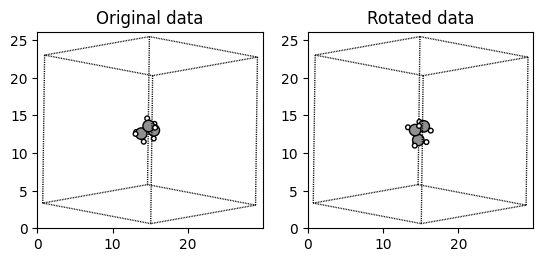

In [28]:
_, _, test_loader = get_coll_loaders(10)  # returns train, val, test loaders. only take the test data

data = next(iter(test_loader))
data, transformed_data = transform_and_visualize(data)

In [29]:
# choose the sample from the batch (batch_size = 10)
i = 0

# compare the prediction with the true label
print("Predicted energy regular model:\t\t", model(data)[i].item())
print("Predicted energy invariant model:\t", model_inv(data)[i].item())
print()
print("True energy of molecule:\t\t", data.y[i].item())

Predicted energy regular model:		 -3.5298328399658203
Predicted energy invariant model:	 -3.5213706493377686

True energy of molecule:		 -3.347879409790039


## Summary & outlook

In this lab, you have seen how to implement a simple GNN architecture using pytorch-geometric. We then applied the GNN to predict the free energy of a molecule graph. Based on the spatial positions of the atoms in the molecule we implemented different edge features with different invariance features. During the training of the final model we have seen that designing architectures that are themselves invariant to transformations can help as the network does not need to re-learn the relationships.